In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

import spacy
import nltk
import nltk.data
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import regex as re
import string
from collections import defaultdict

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import RandomizedSearchCV

from gensim.models import FastText
from gensim.models.keyedvectors import KeyedVectors

import itertools

In [2]:
df = pd.read_csv('../data/input_tweets.csv')
print(df.head())

   Unnamed: 0         username  \
0           0  cristia89872894   
1           2      sccristiano   
2          12      Atorrante15   
3          16          _fedenb   
4          20  javier_eduardo3   

                                                                                                                                         acctdesc  \
0  Hincha del Apruebo, pero nunca de los Apruebistas...mi izquierda llega sólo hasta Mujica. Me gustan los chistes sobre estupideces posmodernas.   
1                                                                                                                                             NaN   
2                                                                                                                                             NaN   
3                                                                                                                           🍃ρєя αsρєяα α∂ αsтяα💫   
4                                                 

In [3]:
df.drop(columns = ['Unnamed: 0', 'acctdesc' ,'location', 'following', 'followers', 'totaltweets', 'usercreatedts', 'tweetcreatedts', 'retweetcount', 'hashtags', ], inplace = True)
print(df.head(5))

          username  \
0  cristia89872894   
1      sccristiano   
2      Atorrante15   
3          _fedenb   
4  javier_eduardo3   

                                                                                                                                                                                                                                                                            text  \
0                                                              @liznorthon @SoyAIvaro @ursulaeggers @MielyMerken @AlessandriFelip Pillaron al presunto, es de nacionalidad colombiana. No es sorpresa, la violencia es parte del inmigrante de origen colombiano, es su cultura.   
1                                                                                                                                   @ccarvajaly Cuando se den cuenta que eran homicidas o narco y los pillen dirán hemos dado con este inmigrante ilegal que era un delincuente.   
2                                      

In [4]:
df_train, df_test = train_test_split(df, test_size = 0.3, random_state = 42)

print(f'Training set shape: {df_train.shape}')
print(f'Test set shape: {df_test.shape}')

Training set shape: (1400, 3)
Test set shape: (600, 3)


In [5]:
punctuations = "¡!#$%&'()*+,-./:;<=>¿?@[\]^_`{|}~"

def read_txt(filename):
    list = []
    with open(filename, 'r', encoding='utf-8') as f:
        data = f.readlines()
        for line in data:
            list.append(str(line).replace('\n', ''))
    return list

stopwords = read_txt('../data/spanish_stopwords.txt')

stemmer = SnowballStemmer('spanish')

In [6]:
def clean_accents(tweet):
    tweet = re.sub(r"[àáâãäå]", "a", tweet)
    tweet = re.sub(r"ç", "c", tweet)
    tweet = re.sub(r"[èéêë]", "e", tweet)
    tweet = re.sub(r"[ìíîï]", "i", tweet)
    tweet = re.sub(r"[òóôõö]", "o", tweet)
    tweet = re.sub(r"[ùúûü]", "u", tweet)
    tweet = re.sub(r"[ýÿ]", "y", tweet)

    return tweet

def clean_tweet(tweet, stem = False):
    tweet = tweet.lower().strip()
    tweet = re.sub(r'https?:\/\/\S+', '', tweet)
    tweet = re.sub(r'http?:\/\/\S+', '', tweet)
    tweet = re.sub(r'www?:\/\/\S+', '', tweet)
    tweet = re.sub(r'\s([@#][\w_-]+)', "", tweet)
    tweet = re.sub(r"\n", " ", tweet)
    tweet = clean_accents(tweet)
    tweet = re.sub(r"\b(a*ha+h[ha]*|o?l+o+l+[ol]*|x+d+[x*d*]*|a*ja+[j+a+]+)\b", "<risas>", tweet)
    for symbol in punctuations:
        tweet = tweet.replace(symbol, "")
    tokens = []
    for token in tweet.strip().split():
        if token not in punctuations and token not in stopwords:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [7]:
df['text_cleaned'] = df['text'].apply(lambda s : clean_tweet(s))
df_train['text_cleaned'] = df_train['text'].apply(lambda s : clean_tweet(s))
df_test['text_cleaned'] = df_test['text'].apply(lambda s : clean_tweet(s))

print(df_train['text_cleaned'].head(5))

836                                                                                             palesmartfon sale cis tezanos preocupa suban impuestos pagar hotelitos vienen patera o dilapiden chiringuitos feminazis utilidad alguna
575     polishembassyuk ayudan menas pagas cobijo ayudan okupas ocupen casas españoles ayudan imigrantes pateras hoteles todo lujo gobierno deja tirados camioneros españoles gracias demas paises politicos ayudar nuestros camioneros
557                                                                                                                                 tardas menos africano patera marruecos arguineguin camionero español dover espera cruz roja llegada
1235                                                                                                                                                    tambien aunque asi esperanza vez van haber asientos quiero mio nieta inmigrante
1360                                                                    

e:\archivos de programa\python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
e:\archivos de programa\python\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
df_train.drop_duplicates(subset=['text_cleaned'], keep='last', inplace = True)
df_test.drop_duplicates(subset=['text_cleaned'], keep='last', inplace = True)

e:\archivos de programa\python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
e:\archivos de programa\python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


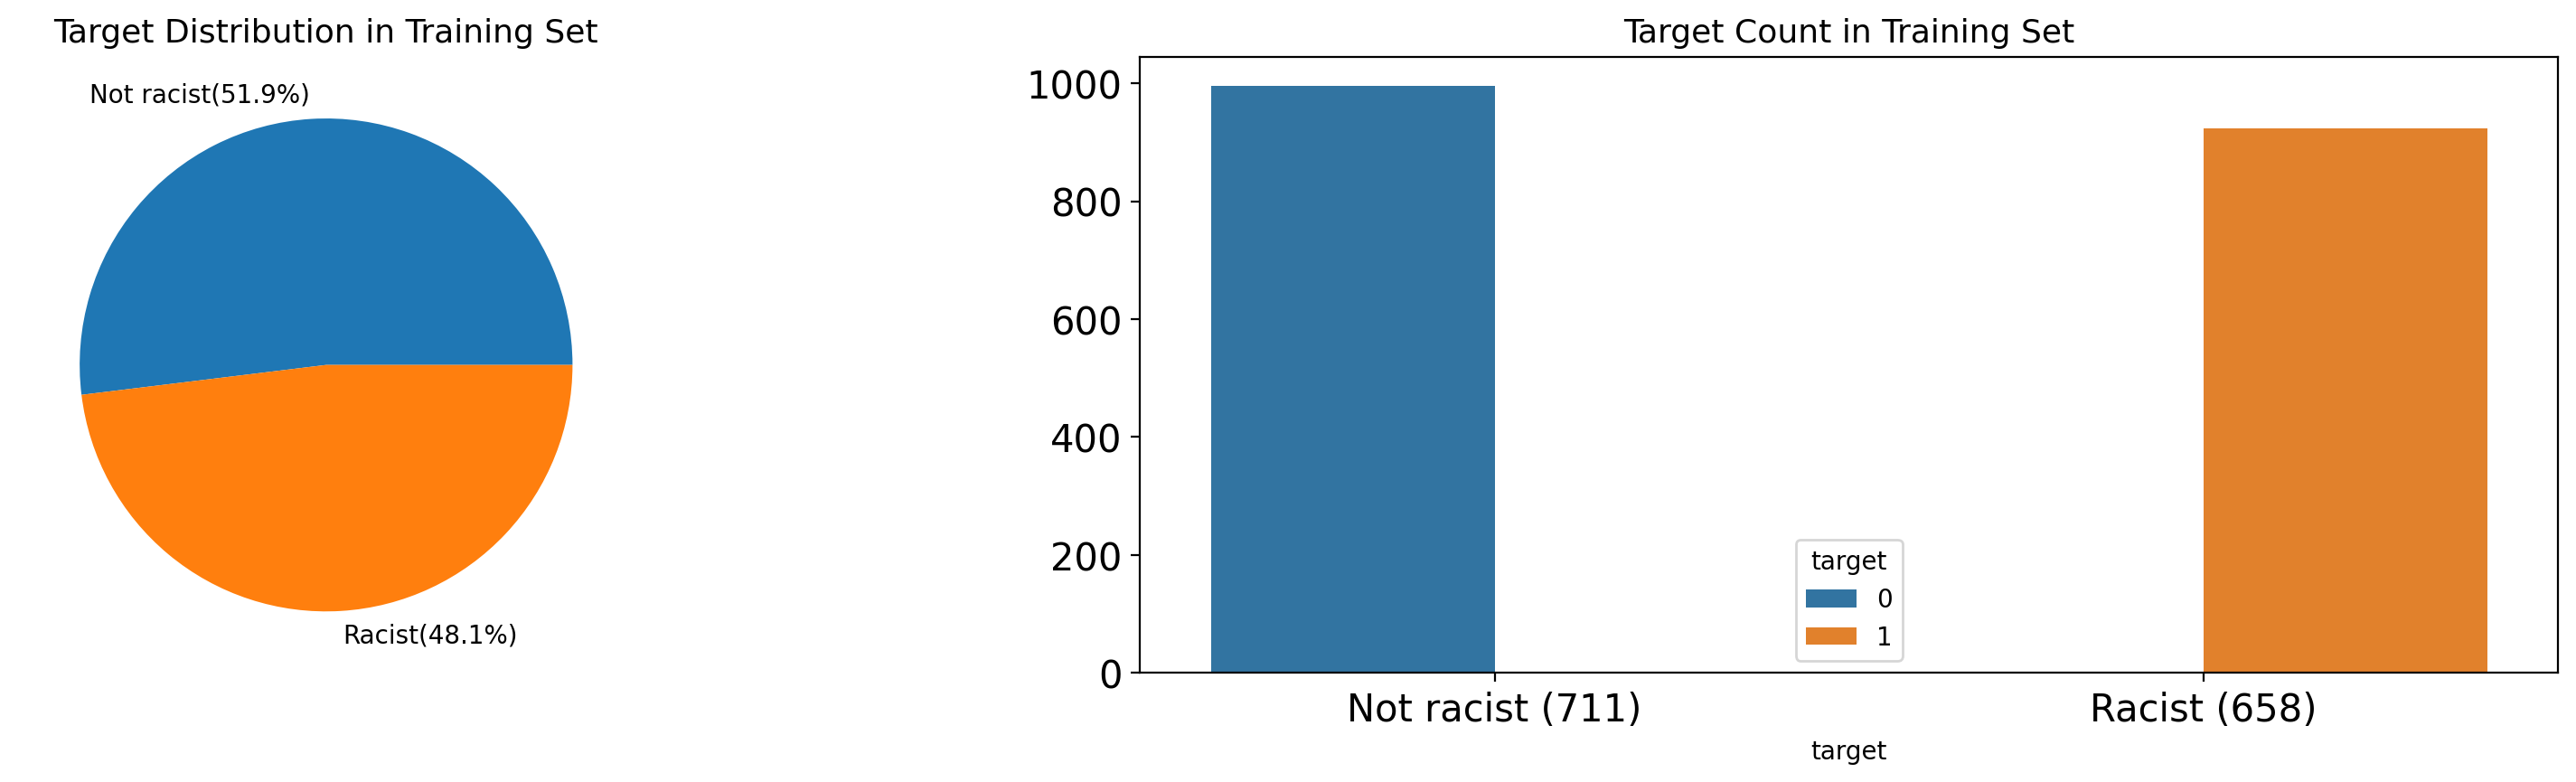

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=200)
plt.tight_layout()

target_count = df_train.groupby('target').count()['username']
not_racist_pct = round(target_count[0]/(target_count[0] + target_count[1]),3)
racist_pct = 1 - not_racist_pct

target_count.plot(kind='pie', ax=axes[0], labels=[f'Not racist({not_racist_pct*100}%)', f'Racist({racist_pct*100}%)'])
sns.countplot(x=df['target'], hue=df['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels([f'Not racist ({target_count[0]})', f'Racist ({target_count[1]})'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text_cleaned)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 10285


In [12]:
MAX_SEQUENCE_LENGTH = 30
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text_cleaned),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text_cleaned),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)
print(x_train[0])

Training X Shape: (1369, 30)
Testing X Shape: (589, 30)
[   0    0    0    0    0    0    0    0    0    0    0    0    0 6100
  245 6101 6102 2866 2324  106  129 6103   57    3    6 6104 1565 1291
 6105  301]


In [13]:
y_train = pd.DataFrame(df_train['target'])
y_test = pd.DataFrame(df_test['target'])

print("Training y Shape:", y_train.shape)
print("Testing y Shape:", y_test.shape)

Training y Shape: (1369, 1)
Testing y Shape: (589, 1)


In [14]:
GLOVE_EMB = '../data/embeddings/embeddings-l-model.vec'
EMBEDDING_DIM = 300
LR = 2e-3
BATCH_SIZE = 100
EPOCHS = 50

In [15]:
cantidad = 1313423
wordvectors = KeyedVectors.load_word2vec_format(GLOVE_EMB, limit=cantidad)

In [16]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        embedding_vector = wordvectors[word]
        embedding_matrix[i] = embedding_vector
    except:
        pass

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(f'Embeddings coverage: {round(nonzero_elements / vocab_size,4)*100}')

Embeddings coverage: 82.84


In [29]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

In [30]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = LSTM(64)(embedding_sequences)
x = Dense(256,name='FC1')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

print(model.summary())

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
embedding_30 (Embedding)     (None, 30, 300)           3085500   
_________________________________________________________________
lstm_30 (LSTM)               (None, 64)                93440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
dense_90 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_30 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_91 (Dense)             (None, 512)               262

In [31]:
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [32]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/50
14/14 [==============================] - 2s 46ms/step - loss: 0.6698 - accuracy: 0.5802 - val_loss: 0.5331 - val_accuracy: 0.7419
Epoch 2/50
14/14 [==============================] - 0s 27ms/step - loss: 0.5427 - accuracy: 0.7292 - val_loss: 0.5532 - val_accuracy: 0.7691

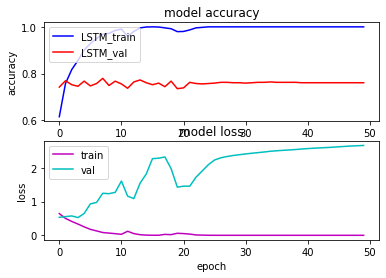

In [41]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [42]:
def decode_sentiment(score):
    return 1 if score>0.5 else 0


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

1/1 [==============================] - 0s 45ms/step


In [43]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

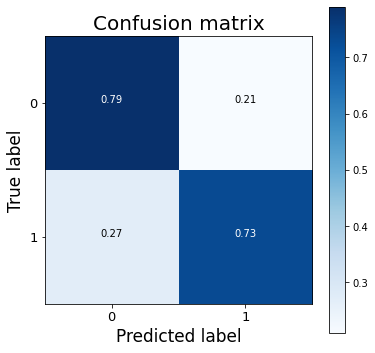

In [44]:
cnf_matrix = confusion_matrix(df_test.target, y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=df_test.target.unique(), title="Confusion matrix")
plt.show()

In [45]:
print(classification_report(list(df_test.target), y_pred_1d))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77       300
           1       0.77      0.73      0.75       289

    accuracy                           0.76       589
   macro avg       0.76      0.76      0.76       589
weighted avg       0.76      0.76      0.76       589



In [46]:
def create_model(num_dense_units, vocab_size, embedding_dim, maxlen, lr):
    embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                              embedding_dim,
                                              weights=[embedding_matrix],
                                              input_length=maxlen,
                                              trainable=False)
    sequence_input = Input(shape=(maxlen,), dtype='int32')
    embedding_sequences = embedding_layer(sequence_input)
    x = LSTM(64)(embedding_sequences)
    x = Dense(256,name='FC1')(x)
    x = Dense(num_dense_units, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_dense_units, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(sequence_input, outputs)
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [49]:
param_grid = dict(num_dense_units=[32, 64, 128, 256, 512],
                  vocab_size=[vocab_size],
                  embedding_dim=[EMBEDDING_DIM],
                  maxlen=[MAX_SEQUENCE_LENGTH],
                  lr = [2e-3, 3e-3, 4e-3])

In [50]:
model = KerasClassifier(build_fn=create_model,
                            epochs=EPOCHS, batch_size=BATCH_SIZE,
                            verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
grid_result = grid.fit(x_train, y_train)

# Evaluate testing set
test_accuracy = grid.score(x_test, y_test)

print(f'Best accuracy: {grid_result.best_score_}')
print(f'Params: {grid_result.best_params_}')
print(f'Test accuracy: {test_accuracy}')

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best accuracy: 0.7348515838384628
Params: {'vocab_size': 10285, 'num_dense_units': 128, 'maxlen': 30, 'lr': 0.002, 'embedding_dim': 300}
Test accuracy: 0.7674023509025574
